# scikit-identification Example

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
from skmid.models import generate_model_parameters, DynamicModel
from skmid.integrator import RungeKutta4

In [70]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

## Initial Parameters

In [167]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


def lorenz_arrays(dt = 0.01, num_steps = 1000):
   # Need one more for the initial values
   xs = np.empty(num_steps + 1)
   ys = np.empty(num_steps + 1)
   zs = np.empty(num_steps + 1)

   # Set initial values
   xs[0], ys[0], zs[0] = (0., 1., 1.05)

   # Step through "time", calculating the partial derivatives at the current point
   # and using them to estimate the next point
   for i in range(num_steps):
      x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
      xs[i + 1] = xs[i] + (x_dot * dt)
      ys[i + 1] = ys[i] + (y_dot * dt)
      zs[i + 1] = zs[i] + (z_dot * dt)

   return xs, ys, zs


In [235]:
# Choose an excitation signal
np.random.seed(42)
N = 2000  # Number of samples
fs = 1  # Sampling frequency [hz]
t = np.linspace(0, (N - 1) * (1 / fs), N)
m=-0.0001
c=1
x=np.arange(N)
f=5

df_input = pd.DataFrame(
    data={
        "u1": m*x + c,
        # "u1": 2 * np.random.random(N),
        # "u2": 2 * np.random.random(N),
        # "u1": np.sin(np.pi * f * x / fs),
        "u2": lorenz_arrays(num_steps=N-1)[0] * 0.01,    
        "u3": 2 * np.random.random(N),
        "u4": lorenz_arrays(num_steps=N-1)[2] * 0.01
    },
    index=t,
)

x0 = [1, -1]  # Initial Condition x0 = [0;0]; [nx = 2]

parameter_dict={"N": N, 
                "fs": fs, 
                "t": t, 
                "x0": x0}
print("Initial Parameters")
print(parameter_dict)
display(df_input.head())
print(df_input.shape)

Initial Parameters
{'N': 2000, 'fs': 1, 't': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.997e+03, 1.998e+03,
       1.999e+03]), 'x0': [1, -1]}


,u1,u2,u3,u4
0.0,1.0000,0.000000,0.749080,0.010500
1.0,0.9999,0.001000,1.901429,0.010220
2.0,0.9998,0.001890,1.463988,0.009957
3.0,0.9997,0.002708,1.197317,0.009711
4.0,0.9996,0.003485,0.312037,0.009480


(2000, 4)


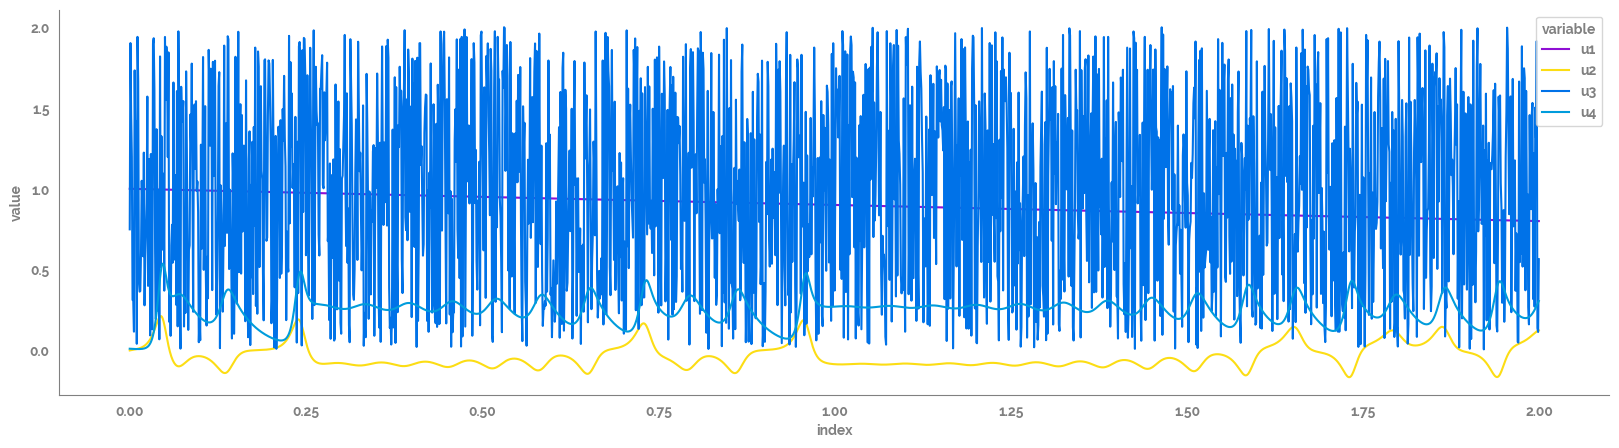

In [222]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df_input
                .reset_index()
                .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable"
                )
_ = sns.despine()

## Symbolics

In [257]:
(x, u, param) = generate_model_parameters(nstate=1, ninput=4, nparam=2)

# assign specific name
# x1, x2 = x[0], x[1]
x1 = x[0]
u1, u2, u3, u4 = u[0], u[1], u[2], u[3]
ka, kb = param[0], param[1]

param_truth = [0.1, 0.5]  # ca.DM([0.1, 0.5])

# rhs = [u1 + ka - x1, u1 + u2 / x1 + u1 / x2 / x1 + kb * x2]
rhs = [(u2 - ka - x1 * u1 * kb + u3 + kb * u4) + u1]
# rhs = [u2 + u4 / x1 + u3 / x1 + kb*u1*u4]
# rhs = [u2*u4/x1 + u3/x1*kb*u4 + u1/x1*kb*u4]
rhs

[MX(@1=u[0], @2=param[1], (((((u[1]-param[0])-((x*@1)*@2))+u[2])+(@2*u[3]))+@1))]

## Define the Dynamic Model

In [258]:
sys = DynamicModel(states=x, inputs=u, param=param, model_dynamics=rhs)
sys.print_summary()

Input Summary
-----------------
states    = ['x1']
inputs    = ['u1', 'u2', 'u3', 'u4']
parameter = ['p1', 'p2']
output    = ['y1']

Dimension Summary
-----------------
 Number of inputs: 3
  Input 0 ("x(t)"): 1x1
  Input 1 ("u(t)"): 4x1
  Input 2 ("p"): 2x1
 Number of outputs: 2
  Output 0 ("xdot(t) = f(x(t), u(t), p)"): 1x1
  Output 1 ("y(t) = g(x(t))"): 1x1


## Run the forward simulation and save the output as a data frame

In [259]:
rk4 = RungeKutta4(model=sys, fs=fs)
rk4.simulate(x0=x0[0], input=df_input, param=param_truth)

df_sim = rk4.output_sim_

display(df_sim.head())
print(df_sim.shape)

,y1
0.0,1.000000
1.0,1.907833
2.0,3.365659
3.0,3.906896
4.0,4.026225


(2001, 1)


## Plot the output

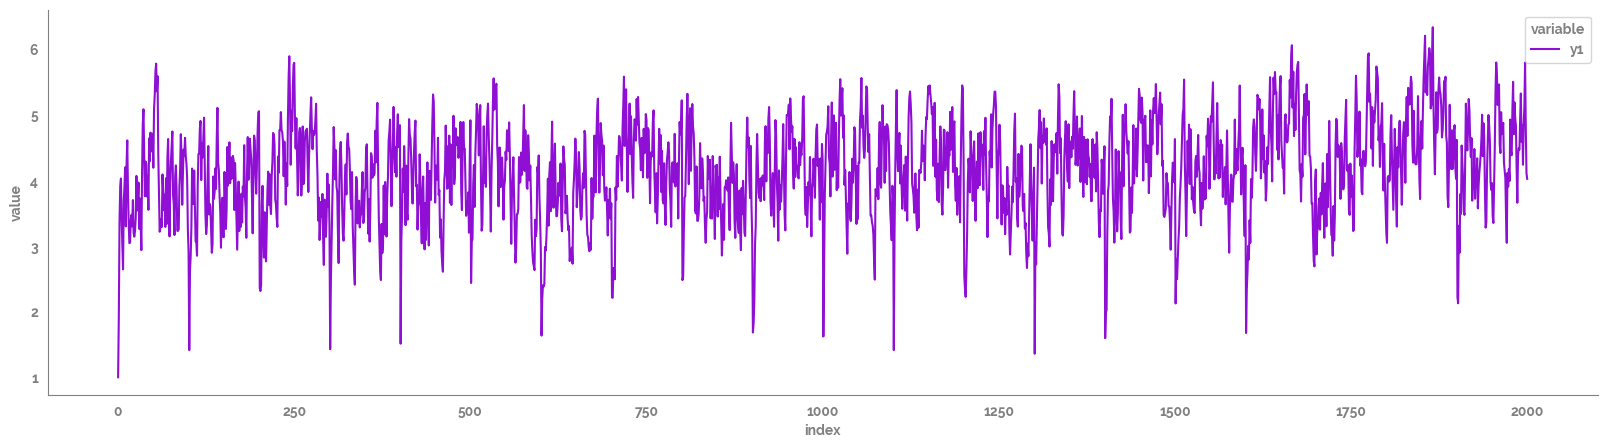

In [260]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df_sim
                .reset_index()
                .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable"
                )
_ = sns.despine()